In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import pymongo
from sklearn import preprocessing
from sklearn.cluster import KMeans
from pymongo import MongoClient
from sklearn.model_selection import train_test_split

In [3]:
# client = MongoClient("mongodb://192.168.1.32:27017/")
# db = client.cricket_data
# collection1 = db.match_data
df_t20 = pd.read_csv('Data LR.csv')
df_t20.head()

AwayTeam Gender           HomeTeam    MatchCity  \
0           Leicestershire   male   Northamptonshire  Northampton   
1          Perth Scorchers   male  Adelaide Strikers          NaN   
2            Gujarat Lions   male    Kings XI Punjab   Chandigarh   
3            Sydney Sixers   male  Adelaide Strikers          NaN   
4  Rising Pune Supergiants   male   Delhi Daredevils        Delhi   

                      MatchDate  MatchId MatchType  \
0  [datetime.date(2016, 6, 26)]   947221       T20   
1   [datetime.date(2015, 1, 6)]   756769       T20   
2  [datetime.date(2016, 4, 11)]   980905       T20   
3  [datetime.date(2012, 1, 10)]   524936       T20   
4   [datetime.date(2016, 5, 5)]   980965       T20   

                                          MatchVenue          MoM  \
0                                      County Ground      JJ Cobb   
1                                      Adelaide Oval      GB Hogg   
2  Punjab Cricket Association IS Bindra Stadium, ...     AJ Finch   
3                                      Adelaide Oval  SNJ O'Keefe   
4                                   Feroz Shah Kotla    AM Rahane   

  TossDecision               TossWinner                          Umpires  \
0        field         Northamptonshire     ['NGC Cowley', 'SA Garratt']   
1        field        Adelaide Strikers       ['GC Joshua', 'DB Mealey']   
2        field            Gujarat Lions  ['AK Chaudhary', 'VA Kulkarni']   
3          bat            Sydney Sixers      ['AJ Barrow', 'MD Martell']   
4        field  Rising Pune Supergiants   ['C Shamshuddin', 'RJ Tucker']   

          WinType                   Winner                       _id  
0  {'wickets': 6}         Northamptonshire  5c41aa4f23099c0a32221b72  
1    {'runs': 18}          Perth Scorchers  5c41aa5523099c0a32221b75  
2  {'wickets': 5}            Gujarat Lions  5c41aa5723099c0a32221b77  
3    {'runs': 64}            Sydney Sixers  5c41aa5723099c0a32221b78  
4  {'wickets': 7}  Rising Pune Supergiants  5c41aa5b23099c0a32221b7b

In [4]:
t20 = pd.read_csv('Data LR2.csv')
t20.head()

Ball      Batsman     Bowler  Innings  MatchId    Nonstrike  Over  \
0     1   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   
1     2   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   
2     3  MJ Cosgrove  MA Ashraf        1   947221   ML Pettini     0   
3     4   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   
4     5   ML Pettini  MA Ashraf        1   947221  MJ Cosgrove     0   

  Player_Out  Run_Batsman  Run_Extras  Total_Runs Wicket_Kind Wicket_taken_By  \
0        NaN            0           0           0         NaN             NaN   
1        NaN            1           0           1         NaN             NaN   
2        NaN            1           0           1         NaN             NaN   
3        NaN            2           0           2         NaN             NaN   
4        NaN            1           0           1         NaN             NaN   

                        _id  Wicket  
0  5c079c8c23099c0b40b327fe       0  
1  5c079c8c23099c0b40b327ff       0  
2  5c079c8c23099c0b40b32800       0  
3  5c079c8c23099c0b40b32801       0  
4  5c079c8c23099c0b40b32802       0

In [5]:
played = {}
def BuildPlayerDict(x):
    for p in x.Batsman.unique():
        if p in played:
            played[p] += 1
        else:
            played[p] = 1

t20.groupby('MatchId').apply(BuildPlayerDict)

def trybuild(lookuplist, buildlist):
    alist = []
    for i in buildlist.index:
        try:
            alist.append(lookuplist[i])
        except:
            alist.append(0)
    return alist

In [6]:
BatsmanStats = t20.groupby('Batsman').aggregate({'Ball': 'count', 'Run_Batsman': 'sum'})

BatsmanStats.rename(columns={'Ball': 'balls', 'Run_Batsman': 'runs'}, inplace=True)
BatsmanStats['strike_rate'] = BatsmanStats['runs']/BatsmanStats['balls']*100
BatsmanStats['matches_played'] = [played[p] for p in BatsmanStats.index]
BatsmanStats['average'] = BatsmanStats['runs']/BatsmanStats['matches_played']

for r in t20.Run_Batsman.unique():
    lookuplist = t20[t20.Run_Batsman == r].groupby('Batsman')['Batsman'].count()
    BatsmanStats[str(r)+'s'] = trybuild(lookuplist, BatsmanStats)

In [7]:
BatsmanStats.head()

balls  runs  strike_rate  matches_played    average  0s  1s  \
Batsman                                                                       
A Ashish Reddy    196   293   149.489796              23  12.739130  54  86   
A Ayre              1     1   100.000000               1   1.000000   0   1   
A Bagai           157   167   106.369427               4  41.750000  45  86   
A Balbirnie        96    87    90.625000               7  12.428571  46  32   
A Bhattarai         3     2    66.666667               1   2.000000   1   2   

                2s  4s  6s  3s  5s  7s  
Batsman                                 
A Ashish Reddy  23  17  15   1   0   0  
A Ayre           0   0   0   0   0   0  
A Bagai         11  14   0   1   0   0  
A Balbirnie      8   9   0   1   0   0  
A Bhattarai      0   0   0   0   0   0

In [8]:
bs = BatsmanStats.reset_index()

bs['boundary_pct'] = ((bs['4s']*4) + (bs['6s']*6))/bs['runs']
bs.head()

Batsman  balls  runs  strike_rate  matches_played    average  0s  \
0  A Ashish Reddy    196   293   149.489796              23  12.739130  54   
1          A Ayre      1     1   100.000000               1   1.000000   0   
2         A Bagai    157   167   106.369427               4  41.750000  45   
3     A Balbirnie     96    87    90.625000               7  12.428571  46   
4     A Bhattarai      3     2    66.666667               1   2.000000   1   

   1s  2s  4s  6s  3s  5s  7s  boundary_pct  
0  86  23  17  15   1   0   0      0.539249  
1   1   0   0   0   0   0   0      0.000000  
2  86  11  14   0   1   0   0      0.335329  
3  32   8   9   0   1   0   0      0.413793  
4   2   0   0   0   0   0   0      0.000000

In [10]:
KM_tb = bs.loc[:,('boundary_pct','average','strike_rate')]
KM_elbow = bs.loc[:,('boundary_pct','average','strike_rate')]

KM_elbow.head()

boundary_pct    average  strike_rate
0      0.539249  12.739130   149.489796
1      0.000000   1.000000   100.000000
2      0.335329  41.750000   106.369427
3      0.413793  12.428571    90.625000
4      0.000000   2.000000    66.666667

In [9]:
KM_elbow.isnull().sum()

boundary_pct    40
average          0
strike_rate      0
dtype: int64

In [11]:
KM_elbow['boundary_pct'] = KM_elbow['boundary_pct'].fillna(KM_elbow['boundary_pct'].mean())
KM_tb['boundary_pct'] = KM_tb['boundary_pct'].fillna(KM_tb['boundary_pct'].mean())
KM_elbow.head()

boundary_pct    average  strike_rate
0      0.539249  12.739130   149.489796
1      0.000000   1.000000   100.000000
2      0.335329  41.750000   106.369427
3      0.413793  12.428571    90.625000
4      0.000000   2.000000    66.666667

In [15]:
KM_tb.head()

boundary_pct    average  strike_rate
0      0.539249  12.739130   149.489796
1      0.000000   1.000000   100.000000
2      0.335329  41.750000   106.369427
3      0.413793  12.428571    90.625000
4      0.000000   2.000000    66.666667

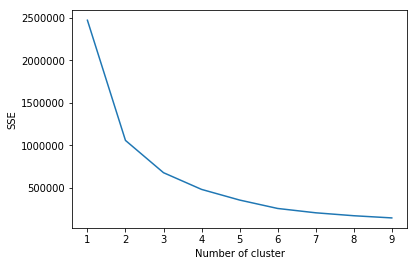

In [21]:
wcss = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters = k).fit(KM_elbow)
    wcss[k]=kmeans.inertia_
plt.figure()
plt.plot(list(wcss.keys()), list(wcss.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [24]:
kmeans = KMeans(n_clusters = 3).fit(KM_tb)
KMtb_clusters = kmeans.predict(KM_tb)
KM_tb['clusters'] = KMtb_clusters

In [25]:
KM_tb.head()

boundary_pct    average  strike_rate  clusters
0      0.539249  12.739130   149.489796         2
1      0.000000   1.000000   100.000000         0
2      0.335329  41.750000   106.369427         0
3      0.413793  12.428571    90.625000         0
4      0.000000   2.000000    66.666667         1

Text(0, 0.5, 'Strike Rate')

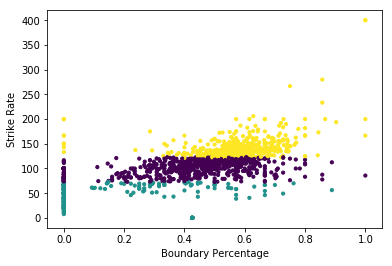

In [29]:
plt.scatter(KM_tb['boundary_pct'], KM_tb['strike_rate'], c=KMtb_clusters, s=10, cmap='viridis')
plt.xlabel("Boundary Percentage")
plt.ylabel("Strike Rate")

C:\Users\Ankit\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


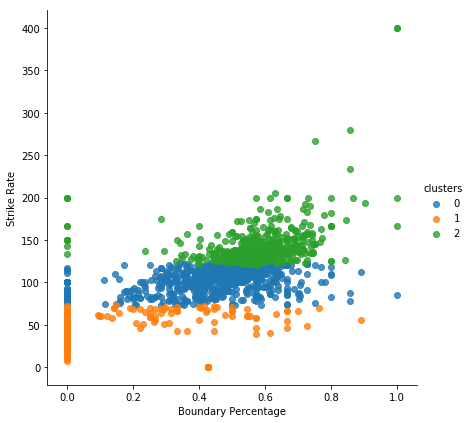

In [32]:
ax = sns.lmplot(data = KM_tb, x='boundary_pct', y='strike_rate', hue='clusters', fit_reg=False, legend=True, size=6)
ax.set(xlabel='Boundary Percentage', ylabel='Strike Rate')
plt.show()

C:\Users\Ankit\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


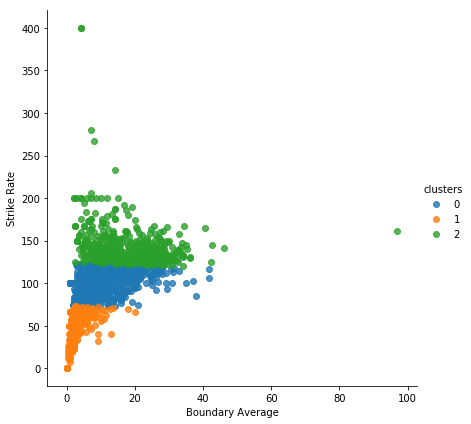

In [35]:
ax = sns.lmplot(data = KM_tb, x='average', y='strike_rate', hue='clusters', fit_reg=False, legend=True, size=6)
ax.set(xlabel='Boundary Average', ylabel='Strike Rate')
plt.show()